In [1]:
from google.colab import drive

drive.mount('./drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./drive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [3]:
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.0MB 25kB/s 
  Found existing installation: tensorflow-gpu 1.5.0
    Uninstalling tensorflow-gpu-1.5.0:
      Successfully uninstalled tensorflow-gpu-1.5.0


In [3]:
import numpy as np

labels_train = np.fromfile('./drive/My Drive/Colab Notebooks/CNN Homework/train_y.bin', dtype=np.uint8).astype(np.int32) - 1
labels_test = np.fromfile('./drive/My Drive/Colab Notebooks/CNN Homework/test_y.bin', dtype=np.uint8).astype(np.int32) - 1

images_train = np.fromfile('./drive/My Drive/Colab Notebooks/CNN Homework/train_X.bin', dtype=np.uint8)
images_train = images_train.reshape(-1, 3, 96, 96)
images_train = np.transpose(images_train, (0, 3, 2, 1)).astype(np.float)

images_test = np.fromfile('./drive/My Drive/Colab Notebooks/CNN Homework/test_X.bin', dtype=np.uint8)
images_test = images_test.reshape(-1, 3, 96, 96)
images_test = np.transpose(images_test, (0, 3, 2, 1)).astype(np.float)

print('[*] Dataset Loaded Successfully!')

[*] Dataset Loaded Successfully!


In [0]:
import tensorflow as tf


train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': images_train},
    y=labels_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True
)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': images_test},
    y=labels_test,
    num_epochs=1,
    shuffle=False
)

In [0]:
def cnn_model_fn(features, labels, mode):
  # Input Layer
    input_layer = tf.reshape(features['x'], [-1, 96, 96, 3])

    # Convolutional Layer 1
    convolution1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    
    convolution1 *= -1
    pooling1 = tf.layers.max_pooling2d(inputs=convolution1, pool_size=[2, 2], strides=2)
    pooling1 *= -1

    # Convolutional Layer 2
    convolution2 = tf.layers.conv2d(
        inputs=pooling1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    
    convolution2 *= -1
    pooling2 = tf.layers.max_pooling2d(inputs=convolution2, pool_size=[2, 2], strides=2)
    pooling2 *= -1
    
    # Convolutional Layer 3
    convolution3 = tf.layers.conv2d(
        inputs=pooling2,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    
    convolution3 *= -1
    pooling3 = tf.layers.max_pooling2d(inputs=convolution3, pool_size=[2, 2], strides=2)
    pooling3 *= -1
    
    # Convolutional Layer 4
    convolution4 = tf.layers.conv2d(
        inputs=pooling3,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    
    convolution4 *= -1
    pooling4 = tf.layers.max_pooling2d(inputs=convolution4, pool_size=[2, 2], strides=2)
    pooling4 *= -1
    
    # Convolutional Layer 5
    convolution5 = tf.layers.conv2d(
        inputs=pooling4,
        filters=128,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu
    )
    
    convolution5 *= -1
    pooling5 = tf.layers.max_pooling2d(inputs=convolution5, pool_size=[2, 2], strides=2)
    pooling5 *= -1
    
    # Dense Layer
    pooling2_flat = tf.reshape(pooling5, [-1, 3 * 3 * 128])
    dense = tf.layers.dense(inputs=pooling2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
      
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])
    }

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir='.drive/My Drive/Colab Notebooks/CNN Homework/Models/conf5')

tensors_to_log = {'probabilities': 'softmax_tensor'}

logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=1)
tf.logging.set_verbosity(tf.logging.INFO)


classifier.train(input_fn=train_input_fn, steps=10, hooks=[logging_hook])

I0723 11:48:13.797978 140322329073536 estimator.py:1790] Using default config.
I0723 11:48:13.802507 140322329073536 estimator.py:209] Using config: {'_model_dir': '.drive/My Drive/Colab Notebooks/CNN Homework/Models/conf5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9f19545b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '

In [11]:
eval_results = classifier.evaluate(input_fn=test_input_fn)
print(eval_results)

I0723 11:50:09.544340 140322329073536 estimator.py:1145] Calling model_fn.
I0723 11:50:09.888888 140322329073536 estimator.py:1147] Done calling model_fn.
I0723 11:50:09.918367 140322329073536 evaluation.py:255] Starting evaluation at 2019-07-23T11:50:09Z
I0723 11:50:10.042254 140322329073536 monitored_session.py:240] Graph was finalized.
W0723 11:50:10.044336 140322329073536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I0723 11:50:10.049356 140322329073536 saver.py:1280] Restoring parameters from .drive/My Drive/Colab Notebooks/CNN Homework/Models/conf5/model.ckpt-10
I0723 11:50:10.114495 140322329073536 session_manager.py:500] Running local_init_op.
I0723 11:50:10.129978 140322329073536 session_manager.py:502] D

KeyboardInterrupt: ignored

In [0]:
from sklearn.metrics import confusion_matrix

predictions = list(classifier.predict(input_fn=test_input_fn))

pred_classes = [p['classes'] for p in predictions]

conf_matrix = confusion_matrix(labels_test, pred_classes)

print(conf_matrix)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from .drive/My Drive/Colab Notebooks/Models/conf4/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[548  17  87   0   2   3   2   2 110  29]
 [110 279  83  49  50   7  59  78  40  45]
 [ 15   6 658   3   0   1   9   1  29  78]
 [ 51  96  54 164  88  16 102 115  50  64]
 [ 83  95  46  68 259   2 125  65  25  32]
 [ 48 110  41  88  52  26 229 151  21  34]
 [ 32  42  49  22  40   5 469  61  13  67]
 [ 24  85  47  85  52   2 132 320  16  37]
 [ 94   3  71   1   1   1   1   2 528  98]
 [ 46   3 299   1   2   0   6   3  98 342]]


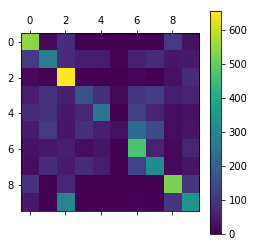

In [0]:
import matplotlib.pyplot as plt


plt.matshow(conf_matrix)
plt.colorbar()
plt.show()